# Data Loading and Visualisation

This notebook is dedicated to developing a flexible framework for loading and visualising the data collected by Lia. Later notebooks will focus on data pre-processing and analysis.

By manually comparing each of the folders shared with us, we found that all folders should have at least 10 items, of which we believe the `.csv` and `.h5` format files to be useful in our analysis. Some of the folders have 11 items, containing an extra `.DAT` file, while others contain 12 items, containing a further `imaging` subfolder within them. Regardless, we will mostly be using the `.h5` and `.csv` files for our analysis, and so we will be focusing on loading these and visualising their contents.

We note that one of the folders, `2024_08_01_0900225B_25um_10Hz.raw` originally did not contain a `.csv` file. However, there seemed to be 2 copies of this folder in 2 of the other folders (1 copy in each of these folders). We extracted these copies and compared them with the original. Both of these copies contained a `.csv` file, but one of these was empty. At the end, we retained the  folder that had the non-empty `.csv` and renamed it to `2024_08_01_0900225B_25um_10Hz.raw`. This is the folder we will be using from now.

## Setup

Let us import some of the necessary libraries and store the names of the files, along with their filepaths, that we need to work with later on.

In [1]:
import h5py
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist

cd = Path(os.getcwd())
print(f"Current directory: {cd}")

Current directory: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis


In [2]:
from pathlib import Path

def list_folders_excluding(exclude_names=(), base_path=None):
    """
    Return folder names in the current or specified directory, excluding any specified.

    Parameters:
    - exclude_names (tuple of str): Folder names to exclude.
    - base_path (str or Path, optional): Directory to search in. Defaults to cwd.

    Returns:
    - list of str: Folder names excluding those in exclude_names.
    """
    path = Path(base_path) if base_path else Path.cwd()
    return [f.name for f in path.iterdir() if f.is_dir() and f.name not in exclude_names]

In [3]:
# Exclude unwanted folders and list relevant ones
folders = list_folders_excluding(exclude_names=('.ipynb_checkpoints', 'Annotations', 'PreppedData', '.git'))
print(f'Number of folders: {len(folders)}')
print('Folder names:')
for folder in folders:
    print(f"{folder}")

Number of folders: 9
Folder names:
2024_07_22_MK483_3_25um_10Hz.raw
2024_07_25_MK503_3_25um_10Hz.raw
2024_07_23_MK478_4_25um_10Hz.raw
2024_08_01_0900225B_25um_10Hz.raw
2024_07_22_MK531_4_25um_10Hz.raw
2024_07_29_MK484_4_25um_10Hz.raw
2024_07_25_MK482_5_25um_10Hz.raw
2024_07_18_MK521_1_25um_10Hz.raw
2024_07_24_MK534_3_25um_10Hz.raw


In [4]:
# Store file paths for the unaligned datacubes
file_paths_unaligned = [cd / folder / 'datacube.h5' for folder in folders]
print(f'Number of unaligned files: {len(file_paths_unaligned)}')
for file_paths in file_paths_unaligned:
    print(f'File paths (unaligned datacubes): {file_paths}')

Number of unaligned files: 9
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK483_3_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK503_3_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_23_MK478_4_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_08_01_0900225B_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK531_4_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_29_MK484_4_25um_10Hz.raw/datacube.h5
File paths (unaligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK482_5_25um_10Hz.raw/datacube.h5
File

In [5]:
# Store file paths for the aligned datacubes
file_paths_aligned = [cd / folder / 'datacube_aligned.h5' for folder in folders]
print(f'Number of aligned files: {len(file_paths_aligned)}')
for file_paths in file_paths_aligned:
    print(f'File path (aligned datacubes): {file_paths}')

Number of aligned files: 9
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK483_3_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK503_3_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_23_MK478_4_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_08_01_0900225B_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK531_4_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_29_MK484_4_25um_10Hz.raw/datacube_aligned.h5
File path (aligned datacubes): /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK482_5_25um_

In [6]:
def explore_h5_file(file_path, show_data=False, max_elements=10):
    """
    Explore and optionally output all contents of an HDF5 (.h5) file.

    Parameters:
        file_path (str or Path): Path to the .h5 file.
        show_data (bool): Whether to print actual dataset contents (limited).
        max_elements (int): Maximum number of data elements to print per dataset.
    """
    file_path = Path(file_path)  # Ensure it's a Path object

    def print_attrs(name, obj):
        print(f"\n{'='*40}\nPath: {name}")
        for key, val in obj.attrs.items():
            print(f"  [Attribute] {key}: {val}")

        if isinstance(obj, h5py.Dataset):
            print(f"  [Dataset] Shape: {obj.shape}, Dtype: {obj.dtype}")
            if show_data:
                data_slice = obj[:] if obj.size <= max_elements else obj[:max_elements]
                print(f"  [Data] \n {data_slice}")
        elif isinstance(obj, h5py.Group):
            print("  [Group]")

    with h5py.File(file_path, 'r') as f:
        f.visititems(print_attrs)

## Loading in the data, Interpreting it
Now, let us load in, format, and visualise the data in each filepath destination. We will consider the aligned datacubes for each destination for now, since these have already had some pre-processing performed on them, so there are equal numbers of rows in these datacubes. This is more obvious in an example. Let us inspect the first aligned datacube:

In [7]:
### Declare Sample Here ###
sample = 0

In [8]:
print('Folder:', folders[sample])
explore_h5_file(file_paths_aligned[sample], show_data = True)

Folder: 2024_07_22_MK483_3_25um_10Hz.raw

Path: datacube
  [Dataset] Shape: (2947, 40000), Dtype: float64
  [Data] 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Path: dims
  [Dataset] Shape: (2, 1), Dtype: float64
  [Data] 
 [[200.]
 [200.]]

Path: mz
  [Dataset] Shape: (2947, 1), Dtype: float64
  [Data] 
 [[50.00944017]
 [50.06884645]
 [50.21388505]
 [50.25889085]
 [50.28938936]
 [50.38820909]
 [50.44784044]
 [50.60508226]
 [50.65463517]
 [50.73192857]]


From the above, using sample $1$ (indexed as $0$) as the working example, we see that the `datacube` obtained from the first file location is a matrix where each column represents a pixel in a `(200,200)` mass spectrometry image (MSI), for a total of `40000` pixels. Each row corresponds to an intensity value for a specific mass-to-charge, i.e. m/z, ratio (2947 m/z values in total), capturing the ion intensities at different mass-to-charge ratios for each pixel. The `dims` dataset provides the image dimensions, `(200,200)` pixels, and the `mz` array lists the specific m/z values corresponding to the rows in the datacube, for which intensity measurements have been made.

In [9]:
def load_msi_h5(file_path, dataset_key=None, verbose=False):
    """
    Load MSI data from an HDF5 (.h5) file.

    Parameters:
        file_path (str or Path): Path to the .h5 file.
        dataset_key (str, optional): Key to a specific dataset within the file.
                                     If None, lists all keys and returns the first dataset found.
        verbose (bool): If True, prints dataset structure.

    Returns:
        np.ndarray: Loaded MSI data (e.g., intensity matrix or image cube).
    """
    file_path = Path(file_path)  # Ensure Path object

    with h5py.File(file_path, 'r') as h5_file:
        if verbose:
            print("Available keys in HDF5 file:")
            def printname(name): print(name)
            h5_file.visit(printname)

        if dataset_key is None:
            dataset_keys = list(h5_file.keys())
            if not dataset_keys:
                raise ValueError("No datasets found in the HDF5 file.")
            dataset_key = dataset_keys[0]
            if verbose:
                print(f"No dataset_key provided. Using '{dataset_key}'.")

        data = np.array(h5_file[dataset_key][:])
        if verbose:
            print('Missing Values in data:', np.isnan(data).any())
        return data.shape

In [10]:
sample = 0
print('Folder:', folders[sample])
print(load_msi_h5(file_path = file_paths_aligned[sample], dataset_key = 'datacube', verbose = True))
# load_msi_h5(file_path = file_paths_unaligned[sample], dataset_key = 'datacube', verbose = True)

Folder: 2024_07_22_MK483_3_25um_10Hz.raw
Available keys in HDF5 file:
datacube
dims
mz
Missing Values in data: False
(2947, 40000)


We have ensured that there are no missing values in any of these datacubes.

## Visualising the MSI images from each folder

In [11]:
def plot_tic(datacube_path, method='max', signal_threshold=1e6, verbose=True, plot = True, save=True):
    """
    Loads the MSI datacube, calculates the Total Ion Current (TIC),
    normalizes it, plots the result, and optionally saves the image in the same folder as the datacube.

    Parameters:
    - datacube_path (str or Path): Path to the datacube file (.h5).
    - method (str): Normalization method. Options are:
        - 'max': scale by max to [0, 1]
        - 'zscore': (value - mean) / std
        - 'minmax255': scale to [0, 255] and convert to uint8
    - signal_threshold (float): Minimum total signal to consider for plotting.
    - verbose (bool): If True, prints messages about skipped files or processing info.
    - save (bool): If True, saves the resulting TIC image in the same directory as the datacube.
    """
    datacube_path = Path(datacube_path)

    with h5py.File(datacube_path, 'r') as f:
        datacube = f['datacube'][:]
        dims = f['dims'][:]

    total_signal = np.sum(datacube)
    if total_signal < signal_threshold:
        if verbose:
            print(f"Skipping file due to low total signal: {total_signal:.2e} ({datacube_path})")
        return None
    
    tic = np.sum(datacube, axis=0)
    print(tic.shape)
    if method == 'max':
        tic_norm = tic / np.max(tic)
    elif method == 'zscore':
        tic_norm = (tic - np.mean(tic)) / np.std(tic)
    elif method == 'minmax255':
        tic_norm = (tic - np.min(tic)) / (np.max(tic) - np.min(tic))
        tic_norm = (tic_norm * 255).astype(np.uint8)
    else:
        raise ValueError(f"Unknown normalization method: {method}")

    height, width = int(dims[0].item()), int(dims[1].item())
    tic_image = tic_norm.reshape(height, width, order = 'F')
    if plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(tic_image.T, cmap='inferno', interpolation='nearest')
        plt.gca().invert_yaxis()
        plt.colorbar(label='TIC' if method != 'minmax255' else 'TIC (0–255)')
        plt.title(f'Total Ion Current (TIC) – {method} normalized\n {datacube_path.stem}')
        plt.axis('off')
        plt.show()
        plt.close()

    if save:
        output_dir = datacube_path.parent
        filename = datacube_path.stem + f"_tic_{method}.png"
        save_path = output_dir / filename
        plt.imsave(save_path, tic_image, cmap='inferno')
        if verbose:
            print(f"TIC image saved to: {save_path}")

    return tic_image

We also define a function to plot the optical image of the sample as well:

In [12]:
def plot_optical_images(base_path='.', folder_name=None, filename=None, save = True):
    """
    Searches subfolders for .png images and plots them.

    Parameters:
    - base_path (str or Path): Base directory to search (default: current directory).
    - folder_name (str, optional): Name of a specific subfolder to process. If None, all subfolders are checked.
    - filename (str, optional): Specific image filename to load. If None, the first .png file found is used.
    """
    base_path = Path(base_path)
    
    target_folders = [folder_name] if folder_name else [f for f in base_path.iterdir() if f.is_dir()]

    for folder in target_folders:
        folder_path = base_path / folder
        png_files = [f for f in folder_path.iterdir() if f.suffix.lower() == '.png']

        if not png_files:
            print(f"No .png files found in: {folder_path}")
            continue

        # Get all PNG files that do NOT contain 'datacube' in their filename
        valid_png_files = [f for f in png_files if 'datacube' not in f.name.lower()]
        
        # Choose the matching filename if it exists and also doesn't contain 'datacube'
        if filename in [f.name for f in valid_png_files]:
            img_file = filename
        elif valid_png_files:
            img_file = valid_png_files[0].name
        else:
            raise FileNotFoundError("No valid PNG files found that exclude 'datacube' in the name.")
        
        img_path = folder_path / img_file

        # Load and plot the image
        img = Image.open(img_path)

        plt.figure(figsize=(6, 5))
        plt.imshow(img)
        plt.title(f'{img_file}')
        plt.axis('off')
        plt.show()
        plt.close()

Folder: 2024_08_01_0900225B_25um_10Hz.raw
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_08_01_0900225B_25um_10Hz.raw/datacube_aligned.h5
(84000,)


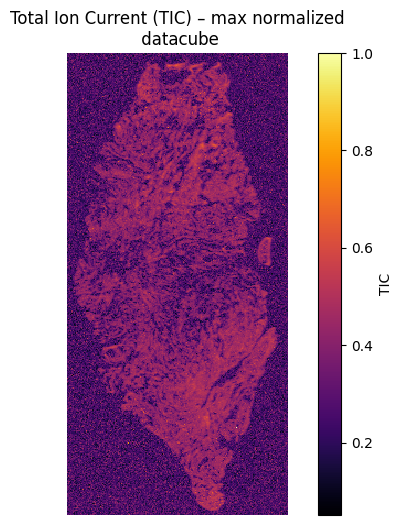

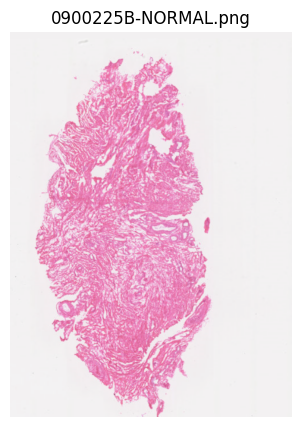

In [13]:
sample_plot, sample_plot_2 = (3, 3)
print('Folder:', folders[sample_plot])
# Path to aligned datacube (adjust as necessary)
print(file_paths_aligned[sample_plot])
datacube_path = file_paths_unaligned[sample_plot]

# Call the function to plot normalised TIC
plot_tic(datacube_path, method = 'max', save = False)
plot_optical_images(folder_name = folders[sample_plot_2])

The above discussion applies to any of the other files we have chosen to analyse. However, we note that not all of the files contain 'square' MSIs, and the length and width of these do not match. This is not a problem; it is just a point to note.

## Loading in the pathology labellings

Now that we understand the data in the datacubes, we turn our attention to the `.csv` files to find out the pathology labellings they contain.

In [14]:
from pathlib import Path
import os

def get_csv_names(
    directory = Path(os.getcwd()),
    recursive = True,
    exclude_folders = None,
    exclude_filenames = None
):
    """
    Returns a list of all .csv file paths in the given directory,
    skipping any files in excluded folders, with excluded filenames,
    or whose name starts with 'imputed'.

    Parameters:
    - directory (Path or str): The root directory to search in.
    - recursive (bool): If True, search subdirectories recursively.
    - exclude_folders (list of str, optional): Folder names to skip.
    - exclude_filenames (list of str, optional): Filenames (without .csv) to skip.

    Returns:
    - List of Path: CSV file paths passing the filters.
    """
    if exclude_folders is None:
        exclude_folders = []
    if exclude_filenames is None:
        exclude_filenames = []

    pattern = "**/*.csv" if recursive else "*.csv"
    all_csvs = directory.glob(pattern)

    filtered = []
    for p in all_csvs:
        # skip if in an excluded folder
        if any(part in exclude_folders for part in p.parts):
            continue

        # skip if filename (without extension) matches explicitly excluded names
        if p.stem in exclude_filenames:
            continue

        # skip if filename starts with 'imputed'
        if p.name.lower().startswith('imputed'):
            continue

        filtered.append(p)

    return filtered

In [15]:
csv_files_paths = get_csv_names(directory = Path(os.getcwd()), 
                                exclude_folders = ['Annotations'],
                                exclude_filenames = ['imputed_MK478_CSV.csv', 'imputed_0900225B_normal.csv'],
                                recursive = True)
for csv in csv_files_paths:
    print(csv)

/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK483_3_25um_10Hz.raw/MK483_CSV.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK503_3_25um_10Hz.raw/MK503_CSV.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_23_MK478_4_25um_10Hz.raw/MK478_CSV.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_08_01_0900225B_25um_10Hz.raw/0900225B_normal.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_22_MK531_4_25um_10Hz.raw/MK531_CSV.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_29_MK484_4_25um_10Hz.raw/MK484_CSV.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_25_MK482_5_25um_10Hz.raw/MK482_CVS.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_18_MK521_1_25um_10Hz.raw/MK521_CIN1.csv
/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_24_MK534_3_25um_10Hz.raw/MK534_CSV.csv


In [16]:
import pandas as pd
sample = 3
csv_readin = csv_files_paths[sample] 

# Try loading the file
try:
    df_labels = pd.read_csv(csv_readin)
    print(f"Shape: {df_labels.shape}")
    print("First few rows:")
    print(display(df_labels))
    print(f"Memory usage: {df_labels.memory_usage(deep=True).sum() / 1e6:.2f} MB")
except Exception as e:
    print("Error loading CSV file:")
    print(e)

Shape: (755, 2949)
First few rows:


,ID,Label,50.0094401672363,50.0688464477539,50.2138850524902,50.2588908508301,50.2893893554688,50.3882090881348,50.447840435791,50.6050822570801,...,1196.19197724609,1196.94295380859,1197.12715791016,1197.53121064453,1198.50252412109,1198.84285615234,1199.32515595703,1199.60176728516,1199.99214814453,1200.48873017578
0,1,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,15.934339,32.952888,32.952888,32.952888,39.471361,0.000000,0.000000,0.0,0.0,0.0
2,3,normal 1,0.0,0.0,0.0,0.0,0.0,52.615613,52.615613,52.615613,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,4,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,54.633350,50.633423,50.633423,50.633423,49.101364,48.073991,46.162331,0.0,0.0,0.0
4,5,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,751,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
751,752,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
752,753,normal 1,0.0,0.0,0.0,0.0,0.0,121.054541,121.054541,121.054541,...,32.096092,2.339254,2.339254,2.339254,0.000000,0.000000,0.000000,0.0,0.0,0.0
753,754,normal 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,118.827447,13.068899,13.068899,13.068899,4.800000,0.000000,0.000000,0.0,0.0,0.0


None
Memory usage: 17.85 MB


In [17]:
print(df_labels['Label'].unique())
mz_from_csv = df_labels.columns.difference(['ID', 'Label'])  # Excludes 'Label' and index
print(len(mz_from_csv))  # Should be 2947

['normal 1']
2947


In [18]:
row_counts = []
for index, csv in enumerate(csv_files_paths):
    loaded = csv_files_paths[index]
    df_ = pd.read_csv(loaded)
    print(df_.shape)
    row_counts.append(df_.shape[0])
print(np.sum(np.array(row_counts)))

(827, 2949)
(191, 2949)
(167, 2949)
(755, 2949)
(217, 2949)
(281, 2949)
(152, 2949)
(369, 2949)
(106, 2949)
3065


In [ ]:
(281, 2949)
(106, 2949)
(827, 2949)
(191, 2949)
(217, 2949)
(152, 2949)
(369, 2949)

# Inspecting the `.csv` files, imputing where necessary

Having loaded in the `.csv`, we find that the number of (numerical) columns (excluding 'Label' and 'ID') is the same as the number of rows in the corresponding datacube. However, we find a mismatch in the opposite case, i.e., between the number of rows of the `.csv` and the number of columns of the datacube.

We can check if there is a one-to-one correspondence between each row of the `.csv` and some of the columns of the datacube, to confirm if the data in the `.csv` represents a subset of the data in the datacube, say, over the annotated regions in the samples. In this setting, we take the rows of a `.csv` and the columns of its corresponding datacube to contain the spectral intensities over the m/z values.

We can write a function to do this (see below), but said function would not be particularly fast to execute, since it would not been maximally-vectorised. This deliberate restriction would need to be in place, since the memory costs for a maximally-vectorised approach would likely be high. Since we are working with medium-sized datasets, with ~100-800$\times$2949 entries, we can slightly loosen this restriction and implement something akin to a vectorised approach.

More importantly, the fact that we are working with a subset of the datacube information in each `.csv` makes things more complicated. The lack of a one-to-one mapping between the two data sources means that, at least in the first instance, we need to take each row and check it against each column of the data frame and find the best matches. Obviously, this approach would take a lot of time. At least for now, we will stick with approach.

Before that however, let us ensure that there are no missing values in our `.csv`'s since this will make our label-matching process more inconvenient. We will also check if the `NaN`'s occur in continuous blocks, or in individual pixels. If they occur in blocks, then the imputation can be simplified further.

In [19]:
def check_consecutive_nans(df):
    results = {}
    for idx, row in df.iterrows():
        nan_mask = row.isna().values
        nan_indices = np.where(nan_mask)[0]

        if len(nan_indices) > 1:
            # Check if all NaN indices are consecutive
            diffs = np.diff(nan_indices)
            is_consecutive = np.all(diffs == 1)
        else:
            is_consecutive = len(nan_indices) == 1  # Single NaN is trivially consecutive

        if nan_indices.size > 0:
            results[idx] = {
                "nan_columns": nan_indices.tolist(),
                "consecutive": is_consecutive
            }

    return results

In [20]:
for i, csv_path in enumerate(csv_files_paths):
    print(f'Sample: {i}')
    try:
        df = pd.read_csv(csv_path)
        print(f"Shape: {df.shape}")
    except Exception as e:
        print("Error loading CSV file:")
        print(e)
        continue  # Skip this file if it fails to load

    # Find rows and columns with NaNs
    missing_rows = df[df.isnull().any(axis=1)].index.tolist()
    missing_cols = df.columns[df.isnull().any()].tolist()
    results_i = check_consecutive_nans(df)
    print(results_i)
    
    total_nans = df.isna().sum().sum()
    print(f'Number of missing values in .csv file: {total_nans} \n')

Sample: 0
Shape: (827, 2949)
{}
Number of missing values in .csv file: 0 

Sample: 1
Shape: (191, 2949)
{}
Number of missing values in .csv file: 0 

Sample: 2
Shape: (167, 2949)
{166: {'nan_columns': [2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 

Now, since we know that the contents of `.csv` files represent a subset of the data in their corresponding datacubes, namely the data over the annotated regions, we can adjust the contents of the `.csv` files. We also know that there are `NaN`'s in the last rows of both samples 3 and 4, and we also know the starting positions of the `NaN`'s in these rows, and that they run uninterrupted until the ends of the rows. Given this knowledge, we can consider a segment of these rows, up to some index, where the `NaN`'s start, and compare these segments against each of the columns of their corresponding datacubes. We truncate all the columns to match the row segments in length.

Once matching segments up to the points of divergence are identified, we impute the rows past their points of divergence with values from their best-match column.

We note that this simplistic imputation approach only applies in our scenario, and would now generalise to cases, e.g. where random pixels have missing data.

In [21]:
# --- Setup ---
sample = 2
base_path = os.getcwd()
folder_path = os.path.join(base_path, folders[sample])

# Load datacube
h5_file = next(f for f in os.listdir(folder_path) if f.endswith('aligned.h5'))
with h5py.File(os.path.join(folder_path, h5_file), 'r') as f:
    datacube = f['datacube'][:]  # shape: (mz, n_samples)

# Load CSV
csv_file = next(f for f in os.listdir(folder_path) if f.endswith('.csv') and not f.startswith('imputed_'))
df = pd.read_csv(os.path.join(folder_path, csv_file))

# --- Extract last row ---
spectra = df.drop(columns=['ID', 'Label']).to_numpy()
last_row = spectra[-1]

# --- Pinpoint the neighbourhood of divergence ---
print('Neighbourhood of divergence:')
print(datacube[:2729, 13574])
print(last_row[:2729])

# Find first NaN index
nan_start_idx = np.where(np.isnan(last_row))[0][0]
# Optionally match only up to one value before NaNs
match_idx = nan_start_idx - 1

known_segment = last_row[:match_idx]

# --- Tolerance ---
tol = 1e-5
best_idx = None

for i in range(datacube.shape[1]):
    candidate_segment = datacube[:match_idx, i]
    if np.allclose(candidate_segment, known_segment, atol=tol, rtol=0):
        best_idx = i
        print(f"✅ Match found at datacube column {i} (compared up to index {match_idx})")
        break

if best_idx is None:
    print("❌ No matching datacube column found.")
else:
    # Impute from the *next* index after match_idx
    imputed_values = datacube[match_idx:, best_idx]

    # Fill from match_idx onward (not just nan_start_idx)
    spectra[-1, match_idx:] = imputed_values

    # Put back into dataframe
    df.iloc[-1, 2:] = spectra[-1]

    print(f"✅ Imputed values from datacube column {best_idx}, starting at index {match_idx}")
    # Save the imputed DataFrame
    imputed_filename = f"imputed_{csv_file}"
    imputed_path = os.path.join(folder_path, imputed_filename)
    df.to_csv(imputed_path, index=False)
    print(df.shape)
    
    print(f"💾 Imputed DataFrame saved to: {imputed_path}")

Neighbourhood of divergence:
[  0.           0.           0.         ... 145.32780962 216.28053063
 125.7862973 ]
[  0.           0.           0.         ... 145.32780962  21.
          nan]
✅ Match found at datacube column 13574 (compared up to index 2727)
✅ Imputed values from datacube column 13574, starting at index 2727
(167, 2949)
💾 Imputed DataFrame saved to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_07_23_MK478_4_25um_10Hz.raw/imputed_MK478_CSV.csv


In [22]:
# --- Setup ---
sample = 3
base_path = os.getcwd()
folder_path = os.path.join(base_path, folders[sample])

# Load datacube
h5_file = next(f for f in os.listdir(folder_path) if f.endswith('aligned.h5'))
with h5py.File(os.path.join(folder_path, h5_file), 'r') as f:
    datacube = f['datacube'][:]  # shape: (mz, n_samples)

# Load CSV
csv_file = next(f for f in os.listdir(folder_path) if f.endswith('.csv') and not f.startswith('imputed_'))
df = pd.read_csv(os.path.join(folder_path, csv_file))

# --- Extract last row ---
spectra = df.drop(columns=['ID', 'Label']).to_numpy()
last_row = spectra[-1]

# --- Pinpoint the neighbourhood of divergence ---
print('Neighbourhood of divergence:')
print(datacube[:2916, 26481])
print(last_row[:2916])

# Find first NaN index
nan_start_idx = np.where(np.isnan(last_row))[0][0]
# Optionally match only up to one value before NaNs
match_idx = nan_start_idx - 1

known_segment = last_row[:match_idx]

# --- Tolerance ---
tol = 1e-5
best_idx = None

for i in range(datacube.shape[1]):
    candidate_segment = datacube[:match_idx, i]
    if np.allclose(candidate_segment, known_segment, atol=tol, rtol=0):
        best_idx = i
        print(f"✅ Match found at datacube column {i} (compared up to index {match_idx})")
        break

if best_idx is None:
    print("❌ No matching datacube column found.")
else:
    # Impute from the *next* index after match_idx
    imputed_values = datacube[match_idx:, best_idx]

    # Fill from match_idx onward (not just nan_start_idx)
    spectra[-1, match_idx:] = imputed_values

    # Put back into dataframe
    df.iloc[-1, 2:] = spectra[-1]

    print(f"✅ Imputed values from datacube column {best_idx}, starting at index {match_idx}")
    # Save the imputed DataFrame
    imputed_filename = f"imputed_{csv_file}"
    imputed_path = os.path.join(folder_path, imputed_filename)
    df.to_csv(imputed_path, index=False)
    print(df.shape)
    
    print(f"💾 Imputed DataFrame saved to: {imputed_path}")

Neighbourhood of divergence:
[  0.           0.           0.         ... 133.30119948 133.42758415
 133.4947671 ]
[  0.           0.           0.         ... 133.30119948 133.42758
          nan]
✅ Match found at datacube column 26481 (compared up to index 2914)
✅ Imputed values from datacube column 26481, starting at index 2914
(755, 2949)
💾 Imputed DataFrame saved to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/2024_08_01_0900225B_25um_10Hz.raw/imputed_0900225B_normal.csv
